# 2020-06-01 Does Qutip's Heterodyne Milstein integrator is really of strong convergence order 1?

Resutls below show that it is **NOT**: we get an order 0.5 integrator. 

There must be an error in the last milstein term for heterodyne detection (e.g. in bi'bi?).
I have not found the error yet in stochastic.pyx.

-------

We are interested in qutip's stochastic solver **'smesolve'**, to verify wether it reaches the desired strong convergence.
           
We are refering to Jonathan A. Gross code https://pysme.readthedocs.io/en/latest/testing.html,

and this notebbok https://nbviewer.jupyter.org/github/IanHawke/close-enough-balloons/blob/master/00-Close-Enough-Post-Overall.ipynb.

## Stochastic Master Equation

The **homodyne** version is

$$ d \rho = -i \left[H, \rho \right] dt + \gamma dt \left\{c\rho c - \frac{1}{2}(c^\dagger c \rho + \rho c^\dagger c) \right\} + \sqrt{\gamma} dW \left\{c\rho + \rho c^\dagger - Tr\left((c+c^\dagger)\rho\right)\rho \right\}, $$

or equivalently

$$ d \rho = -i \left[H, \rho \right] dt + \mathcal{D}[\sqrt{\gamma}c]\rho dt + \mathcal{H}[\sqrt{\gamma}c]\rho dW $$

- Deterministic part: $dt$ terms
- Stochastic part: $dW$ term: Wiener increments

The **heterodyne** version is just the sum of two homodyne SME with operators 
$c_1=\frac{c}{\sqrt{2}}$, $c_2=-i\frac{c}{\sqrt{2}}$
where $c$ represents the operator being weakly measured.
It gives the following SME

$$ d \rho = -i \left[H, \rho \right] dt + \mathcal{D}[\sqrt{\gamma}c]\rho dt 
+ \frac{1}{2}\left( \mathcal{H}[\sqrt{\gamma}c]\rho dW_1  + \mathcal{H}[-i\sqrt{\gamma}c]\rho dW_2 \right) $$

## Order of convergence

   - The order of convergence is the rate at which the numerical solution approaches the exact one as the mesh is refined. Considering that we're not comparing with an exact solution, we use 3 grid resolutions that are refined at a constant ratio $r=2$ to find the observed order of convergence $O$, which is given by:
   
   $$O = \log_2\left(\frac{\rho_{(4\Delta t)}(T) - \rho_{(2\Delta t)}(T)}{\rho_{(2\Delta t)}(T) - \rho_{(\Delta t)}(T)}\right)$$
    
Here, $\rho$ is the state of the system after it has evolved during a time $T$ using time steps of $\Delta t, 2\Delta t$ or $4\Delta t$

There are 2 subtilities with using stochastic integration:
- Stochastic integration methods have convergence rates that are given as *expectation values* of the convergence rates for each trajectory. $\implies$ Need to average the convergence rate accross many trajectories.
We then average over N>=1000 trajectories.

- Need to use consistent random increments $\Delta W$ (and $\Delta Z$) for each trajectory. See Jonathan's documentation and code below summing the 'even' and 'odd' parts to get the coarser stochastic increments.

**noise** : int, array[int, 1d], array[double, 4d]
       - int : seed of the noise
       - array[int, 1d], length = ntraj, seeds for each trajectories
       - array[double, 4d] (ntraj, len(times), nsubsteps, len(sc_ops)*[1|2])
          -  vector for the noise, the len of the last dimensions is doubled for
          -  solvers of order 1.5. The correspond to results.noise

**solverstring**

Name of the solver method to use for solving the stochastic equations. Valid values are: 
- order 1/2 algorithms: ‘euler-maruyama’, ‘pc-euler’, ‘pc-euler-imp’ 
- order 1 algorithms: ‘milstein’, ‘platen’, ‘milstein-imp’, ‘rouchon’ 
- order 3/2 algorithms: ‘taylor1.5’, ‘taylor1.5-imp’, ‘explicit1.5’ 
- order 2 algorithms: ‘taylor2.0’ 

call help of qutip.stochastic.stochastic_solvers for a description of the solvers. Implicit methods can adjust tolerance via the kw ‘tol’ default is {‘tol’:1e-6}

**Note: We only deal with order <=1 solver in this particular notebook for simplicity of the demonstration of the error in the milstein integrator.**

In [1]:
import qutip
import matplotlib.pyplot as plt
import numpy as np
import time

from tqdm.notebook import tnrange

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
qutip.__version__

'4.5.0'

In [3]:
def l1_norm(vec, axis=None):
    return np.sum(np.abs(vec), axis)

import os, sys
# Function to avoid the prints of qutip.smesolve() function for every trajectory.
# (Quick fix instead of playing with qutip's print setups)
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

with HiddenPrints():
    print("This will not be printed")

print("This will be printed as before")

This will be printed as before


In [4]:
def compute_qutip_convergence(solver, method, N=1000, T=1.0):
    
    # Final time is T.
    times = np.linspace(0.0, T, 8001)
    times_2 = np.linspace(0.0, T, 4001)
    times_4 = np.linspace(0.0, T, 2001)
    
    mean_val = np.zeros([N, 3, len(times)])
    mean_val_2 = np.zeros([N, 3, len(times_2)])
    mean_val_4 = np.zeros([N, 3, len(times_4)])

    rho_0 = 1/2 * (qutip.qeye(2) + qutip.sigmax()/np.sqrt(2) + qutip.sigmay()/np.sqrt(2)) # Initial state
    H = qutip.sigmax() # Rabi drive X
    L = qutip.sigmaz() # Weak measurement of Z

    dWs = np.zeros([N, len(times)-1, 2])

    # Run smesolve() for the smallest step size.
    for traj in tnrange(N, desc='times'):
        with HiddenPrints():
            result = qutip.smesolve(H, rho_0, times, sc_ops=[L], 
                                    e_ops=[qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()], method=method, 
                                    solver=solver)
        # Extract the trajectories
        mean_val[traj, :, :] = [result.expect[0], result.expect[1], result.expect[2]]
        # Extract the corresponding noise dWs
        dWs[traj, :] = result.noise[0, :-1, 0, :]

    # Use the same noise for 2x larger time steps.
    even_dWs = dWs[:, ::2]
    odd_dWs = dWs[:, 1::2]
    dWs_2 = np.hstack(((even_dWs + odd_dWs), np.zeros((N, 1, 2))))
    noise2 = np.zeros((N, len(times_2), 1, 2))
    noise2[:, :, 0, :] = dWs_2

    for traj in tnrange(N, desc='times_2'):
        with HiddenPrints():
            result_2 = qutip.smesolve(H, rho_0, times_2, sc_ops=[L], 
                                      e_ops=[qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()], method=method, 
                                      solver=solver, noise = np.array([noise2[traj, :, :, :]]))
        mean_val_2[traj, :, :] = [result_2.expect[0], result_2.expect[1], result_2.expect[2]]

    # Use the same noise again for 2x larger time steps, i.e. 4x larger than initial step size.
    even_dWs_2 = dWs_2[:, :-1:2]
    odd_dWs_2 = dWs_2[:, 1::2]
    dWs_4 = np.hstack(((even_dWs_2 + odd_dWs_2), np.zeros((N, 1, 2))))
    noise4 = np.zeros((N, len(times_4), 1, 2))
    noise4[:, :, 0, :] = dWs_4

    for traj in tnrange(N, desc='times_4'):
        with HiddenPrints():
            result_4 = qutip.smesolve(H, rho_0, times_4, sc_ops=[L], 
                                      e_ops=[qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()], method=method, 
                            solver=solver, noise = np.array([noise4[traj, :, :, :]]))
        mean_val_4[traj, :, :] = [result_4.expect[0], result_4.expect[1], result_4.expect[2]]

    rhos = np.array([mean_val[:, 0, :], mean_val[:, 1, :], mean_val[:, 2, :]])
    rhos_2 = np.array([mean_val_2[:, 0, :], mean_val_2[:, 1, :], mean_val_2[:, 2, :]])
    rhos_4 = np.array([mean_val_4[:, 0, :], mean_val_4[:, 1, :], mean_val_4[:, 2, :]])

    # For every possible time step (given by coarsest one)
    ind = np.arange(len(times), step=4)[1:]
    ind_2 = np.arange(len(times_2), step=2)[1:]
    
    rate_array = np.zeros((N, (len(times_4)-1)))
    rate_array_p = np.zeros((N, (len(times_4)-1)))

    for idx in range(N):
        rate_array[idx, :] = (np.log(l1_norm(rhos_4[:, idx, 1:] - rhos_2[:, idx, ind_2], 0)) - np.log(l1_norm(rhos_2[:, idx, ind_2] - rhos[:, idx, ind], 0)))/np.log(2)
        rate_array_p[idx, :] = (np.log(l1_norm(rhos_4[:, idx, 1:] - rhos[:, idx, ind], 0)) - np.log(l1_norm(rhos_2[:, idx, ind_2] - rhos[:, idx, ind], 0)))/np.log(2)

    print('Average over the entire trajectory.')
    print('Rate  : ', np.mean(rate_array), '+/- ', np.std(rate_array))

    plt.plot(np.mean(rate_array, 0), label='Mean')
    plt.plot(np.percentile(rate_array, 25, 0), label='25th percentile')
    plt.plot(np.percentile(rate_array, 75, 0), label='75th percentile')
    plt.legend()
    plt.title('Estimated convergence order for {} {}'.format(method, solver))
    plt.show()

    # Only for the final state
    rho = np.array([mean_val[:, 0, -1], mean_val[:, 1, -1], mean_val[:, 2, -1]])
    rho_2 = np.array([mean_val_2[:, 0, -1], mean_val_2[:, 1, -1], mean_val_2[:, 2, -1]])
    rho_4 = np.array([mean_val_4[:, 0, -1], mean_val_4[:, 1, -1], mean_val_4[:, 2, -1]])

    rate_lst = np.zeros(N)

    for idx in range(N): 
        rate_lst[idx] = (np.log(l1_norm(rho_4[:, idx] - rho_2[:, idx], 0)) - np.log(l1_norm(rho_2[:, idx] - rho[:, idx], 0)))/np.log(2)

    print('Only for the final state at time T.')
    print('Rate  : ', np.mean(rate_lst), '+/- ', np.std(rate_lst))

In the following plots, look at the **blue curve**, representing the mean over N trajectories, to get a good estimate of the strong convergence of the integrator.


Average over the entire trajectory.
Rate  :  0.541570818511578 +/-  1.4936553162221262


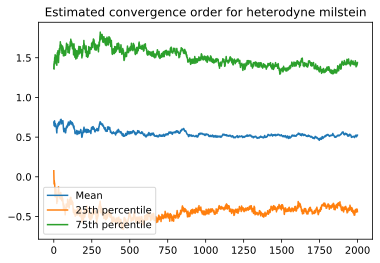

Only for the final state at time T.
Rate  :  0.5242838969033233 +/-  1.3893828258485266


In [5]:
# Takes about 2min.
compute_qutip_convergence(solver='milstein', method='heterodyne', N=1000, T=1.0)

## We see that the heterodyne milstein SME integrator is faulty.

It gives a strong convergence of about 1/2 whereas it is supposed to converge on the order of 1.


Average over the entire trajectory.
Rate  :  1.0168755219951093 +/-  1.2642177741201368


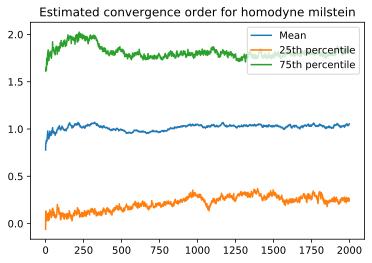

Only for the final state at time T.
Rate  :  1.0555021387168841 +/-  1.2692674903717323


In [6]:
# Takes about 2min.
compute_qutip_convergence(solver='milstein', method='homodyne', N=1000, T=1.0)

### The homodyne version of the milstein scheme is implemented properly as it works as expected (Order~1).

Validation of the convergence of the other integrators for heterodyne SME.


Average over the entire trajectory.
Rate  :  0.4780701316410233 +/-  1.1852399232212056


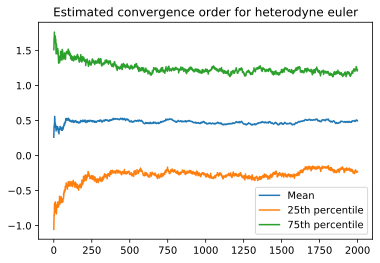

Only for the final state at time T.
Rate  :  0.49674164268403115 +/-  1.1282216418928852


In [7]:
compute_qutip_convergence(solver='euler', method='heterodyne', N=1000, T=1.0)


Average over the entire trajectory.
Rate  :  0.9629319653484214 +/-  1.3431087092654284


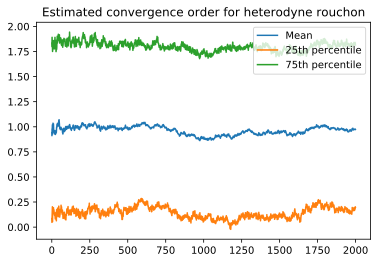

Only for the final state at time T.
Rate  :  0.9728722283157862 +/-  1.381267559025449


In [8]:
compute_qutip_convergence(solver='rouchon', method='heterodyne', N=1000, T=1.0)


Average over the entire trajectory.
Rate  :  0.9924467853963964 +/-  1.1476989074136545


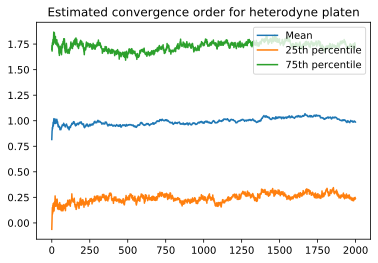

Only for the final state at time T.
Rate  :  0.9871445976919233 +/-  1.1406068128298459


In [9]:
compute_qutip_convergence(solver='platen', method='heterodyne', N=1000, T=1.0)